In [2]:
%config InlineBackend.figure_format = "svg"
%matplotlib inline

# Deutsch Jozsa's Algorithm

This algorithm was one of the first to take advantage of Quantum Computing to demonstrate that it can perform some tasks more efficiently than Classical Computers.

This algorithm is at the heart of a simple question: Say we have a function $f$ that maps an $n$ bit string into a single bit:
$f: \{0, 1\}^n \mapsto \{0, 1\}$

The purpose of the algorithm is therefore to determine if this function is **balanced** or **constant**. Balanced means that the number of bit strings that $f$ maps to $0$ is the same number that it maps to $1$. Constant means that the function has the same output for every possible input.

# Classical Approach

Before diving into the Quantum Algorithm, it is a good exercise to understand how one could implement this classically, so that we can later compare the two methods more easily.

To do this is a classical manner, we have to evaluate $f$ for each possible bit string and count the number of times each result happens.

In [3]:
balanced_f = lambda x: int(x) % 2
constant_f = lambda x: 1

def isBalanced(func, n):
    """
    Verifies if func is balanced or constant
    
    Args:
        - func: The function to be tested
        - n: The number of bits of the bitstrings to be used
    """
    
    total = 2**n
    num_ones = sum([func(x) for x in range(total)])
    
    if num_ones == total / 2:
        print("Function is balanced")
    elif num_ones == total or num_ones == 0:
        print("Function is constant")
    else:
        print("Function is neither")

print ("f(x) = x % 2 --> ", end="")
isBalanced(balanced_f, 16)
print ("f(x) = 0     --> ", end="")
isBalanced(constant_f, 16)

f(x) = x % 2 --> Function is balanced
f(x) = 0     --> Function is constant


Since we have to iterate every since possible bitstring in the function's domain, and since for an $n$ bit bitstring (with no sign bit) we can represent $2^n$ numbers (including zero), the time complexity of this function is:

$$ T(n) = 2^n \Leftrightarrow T(n) \in \Theta(2^n) $$

# Quantum Approach

The key point is that quantum mechanics can test **every single bitstring at the same time** using one of it's fundamental properties: **Superposition**

By using superposition, we can evolve every single possible bitstring, each bit represented by a quantum state-vector, and make them interfere so that we can determine wether $f$ is balanced or not.

Let's take a look at the algorithm's circuit and explain the mathematics behing it:

In [4]:
from qiskit.tools.visualization import plot_histogram
from qiskit.quantum_info.operators import Operator
from qiskit_textbook.tools import array_to_latex
from qiskit import *
import numpy as np

## Qiskit Circuit implementation

In [5]:
def set_bit(value, bit):
    return value | (1<<bit)

def clear_bit(value, bit):
    return value & ~(1<<bit)

def newBitString(func, x):
    r = func(x>>1)
    if r==1 and x%2==0: x = set_bit(x, 0)
    elif r==1 and x%2==1: x = clear_bit(x, 0)
    return x

def unitaryMatrix(func, n):
    """
    Calculates the unitary Bf matrix 
    """
    total = 2**(n+1)
    v = np.array([newBitString(func, x) for x in range(total)])
    r = np.zeros((v.size, v.size))
    r[np.arange(v.size), v] = 1
    
    # Verify that the matrix is unitary
    assert np.array_equal(np.matmul(r, r.T), np.identity(v.size))
    
    return r.T

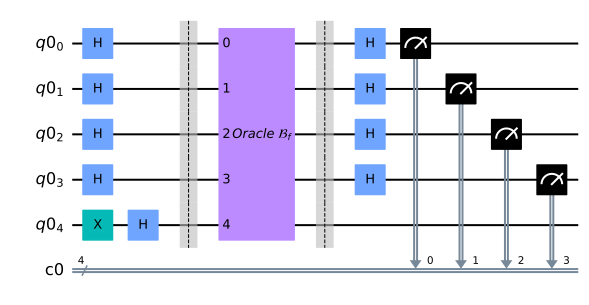

In [6]:
def get_circuit(func, n, verbose=False):
    qr, cr = QuantumRegister(n+1), ClassicalRegister(n)
    circuit = QuantumCircuit(qr, cr)

    unitary = Operator(unitaryMatrix(func, n))
    if verbose: print(unitary)
    circuit.x(n)
    for i in range(n+1): circuit.h(i)
    circuit.barrier()
    circuit.unitary(unitary, [i for i in range(n+1)], label="$ \qquad Oracle \; \mathcal{B}_f \qquad $")
    circuit.barrier()
    for i in range(n): circuit.h(i)
    circuit.measure([i for i in range(n)], [i for i in range(n)])
    
    return circuit

get_circuit(balanced_f, 4).draw(output="mpl")

## Theoretical Description

Before the first barrier, what we have is $n$ QuBits with in the state $|0\rangle$ and $1$ QuBit in the state $|1\rangle$, all going through Hadamard gates. If we name $|\psi_1\rangle$ the state that represents the combination of all these states:

$$ |\psi_1\rangle = \left( \bigotimes_{i=1}^{n} H |0\rangle \right) \otimes H |1\rangle = \left( \bigotimes_{i=1}^{n} \frac{1}{\sqrt{2}} \big( |0\rangle + |1\rangle \big) \right) \otimes \frac{1}{\sqrt{2}} \big( |0\rangle - |1\rangle \big) = \left( \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} |x\rangle \right) \otimes \frac{1}{\sqrt{2}} \big( |0\rangle - |1\rangle \big) $$

After the barrier, we introduce a costum gate $\mathcal{B}_f$. This gate will keep every one of the first $n$ QuBits unchanged, but will modify the last QuBit:

$$ \mathcal{B}_f |\psi_1\rangle = \left( \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} |x\rangle \right) \otimes \frac{1}{\sqrt{2}} \big( |0 \oplus f(x) \rangle - |1 \oplus f(x) \rangle \big) $$

To simplify the expression above, we can notice that $f(x)$ can only output two values:
 
 $$ f(x) = 0 \rightarrow \frac{1}{\sqrt{2}} \big( |0 \oplus f(x) \rangle - |1 \oplus f(x) \rangle \big) = \frac{1}{\sqrt{2}} \big( |0 \rangle - |1 \rangle \big) $$
 
 $$ f(x) = 1 \rightarrow \frac{1}{\sqrt{2}} \big( |0 \oplus f(x) \rangle - |1 \oplus f(x) \rangle \big) = \frac{1}{\sqrt{2}} \big( |1 \rangle - |0 \rangle \big) = - \frac{1}{\sqrt{2}} \big( |0 \rangle - |1 \rangle \big) $$
 
Therefore we can reexpress the last qubit as:
 
$$ \frac{1}{\sqrt{2}} \big( |0 \oplus f(x) \rangle - |1 \oplus f(x) \rangle \big) = \frac{1}{\sqrt{2}} (-1)^{f(x)} \big( |0 \rangle - |1 \rangle \big)  $$

And we can rewrite the effect of $B_f$ on $|\psi_1\rangle$ and call the resulting state $|\psi_2\rangle$:

$$ \mathcal{B}_f |\psi_1\rangle = \left( \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} |x\rangle \right) \otimes \frac{1}{\sqrt{2}} (-1)^{f(x)} \big( |0\rangle - |1\rangle \big) $$

$$ |\psi_2\rangle = \mathcal{B}_f |\psi_1\rangle = \left( \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} (-1)^{f(x)} |x\rangle \right) \otimes \frac{1}{\sqrt{2}} \big( |0\rangle - |1\rangle \big) $$

This manipulation, where this Quantum gate seems to only affect the *state* of one QuBit, but can also be expressed as only affecting the *phases* of every other QuBit, is very common and useful in many Quantum Computing algorithms and is known as the **phase kickback**.

Finally, to get the final state, we just discard the last QuBit and once again apply Hadamard gates to all the remaining ones. By using the identity:

$$ H^{\otimes n} |x\rangle = \frac{1}{\sqrt{2}} \sum_{y \in \{0, 1\}^n} (-1)^{x \cdot y} |y\rangle \;, \quad x \cdot y = \sum_{i=1}^{n} x_i y_i $$

We can determine the final state $|\psi_3\rangle$:

$$ |\psi_3\rangle = H^{\otimes n} \left( \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} (-1)^{f(x)} |x\rangle \right) = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} (-1)^{f(x)} \left( \frac{1}{\sqrt{2}} \sum_{y \in \{0, 1\}^n} (-1)^{x \cdot y} |y\rangle \right) $$

$$ |\psi_3\rangle = \frac{1}{2^n} \sum_{y \in \{0,1\}^n} \left( \sum_{x \in \{0,1\}^n} (-1)^{f(x) + x \cdot y} \right) |y\rangle $$

How does this complicated quantum state help us, exactly?
Well, at the end of the day, what we want to do is take a measurement of the final state to get our final answer. To get aditional information out of this final quantum state, we must calculate measurement probabilities!
It turns out that what we are interested in is the probability that $|\psi_3\rangle$ is a bitstring containing all zeros. If we define $|\phi\rangle = |0\rangle^{\otimes n}$ (a zero bitstring), then the probability of measuring all zeros is given by:

$$ P_{\phi} = |\langle\phi|\psi_3\rangle|^2 = \left| \; \frac{1}{2^n} \sum_{y \in \{0,1\}^n} \left( \sum_{x \in \{0,1\}^n} (-1)^{f(x) + x \cdot y} \right) \langle\phi|y\rangle \; \right|^2 = \left| \; \frac{1}{2^n} \sum_{x \in \{0,1\}^n} (-1)^{f(x) + x \cdot \phi} \; \right|^2 $$

But since we defined:

$$ x \cdot y = \sum_{i=1}^{n} x_i y_i $$

Then $ x \cdot \phi = 0 $ and the probability becomes:

$$ P_{\phi} = \left| \; \frac{1}{2^n} \sum_{x \in \{0,1\}^n} (-1)^{f(x)} \; \right|^2 $$

And finally, we just have to notice that:
- If $f$ is balanced:

$$ \sum_{x \in \{0, 1\}^n} (-1)^{f(x)} = \sum_{i=1}^{2^{n-1}} 1 - \sum_{j=1}^{2^{n-1}} 1 = 0 $$

- And if $f$ in constant:

$$ \sum_{x \in \{0, 1\}^n} (-1)^{f(x)} = ± \sum_{i=1}^{2^n} 1 = ± 2^n $$

Therefore:

$$ f \; \mathtt{is} \; \mathtt{balanced} \rightarrow P_{\phi} = 0 $$
$$ f \; \mathtt{is} \; \mathtt{constant} \rightarrow P_{\phi} = 1 $$

## Simulation using Qiskit Aer

In [63]:
circuit = get_circuit(balanced_f, 1, True)
# simulator = Aer.get_backend('qasm_simulator')
simulator = Aer.get_backend("statevector_simulator")
result = execute(circuit, backend=simulator, shots=2048).result()

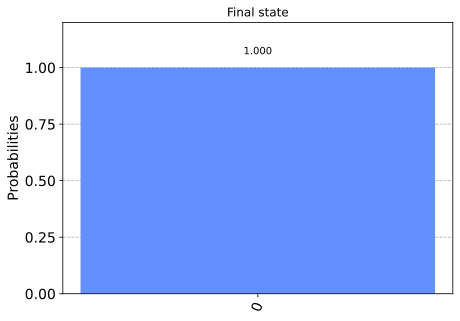

In [55]:
plot_histogram(result.get_counts(circuit), title="Final state")

In [64]:
array_to_latex(result.get_statevector().data, "$|\psi\rangle$")

<IPython.core.display.Math object>